In [9]:
import pandas as pd
t = pd.read_csv("/home/jovyan/work/prj_data/open/train.csv")

### ※ 결측치 확인

In [10]:
import pandas as pd
missing_values = t.isnull().sum()
print(missing_values)

id          0
context     0
question    0
answer      0
dtype: int64


# 1. Sequence Length

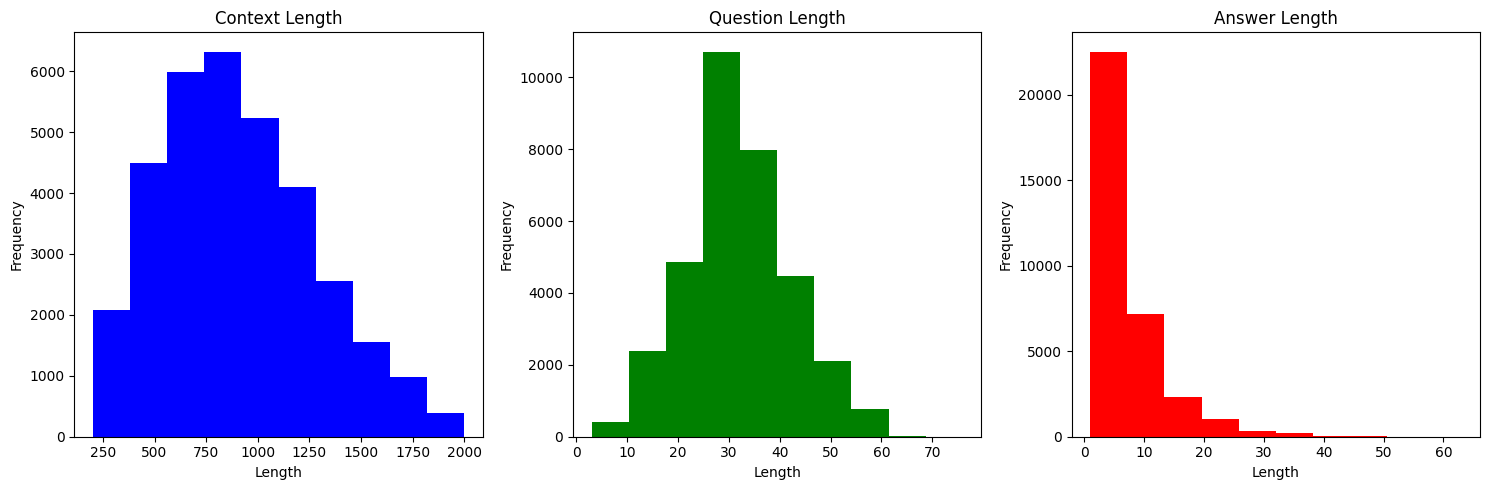

In [11]:
import matplotlib.pyplot as plt

context_l = t['context'].str.len()
question_l = t['question'].str.len()
answer_l = t['answer'].str.len()

l = [context_l, question_l, answer_l]
colors = ['blue', 'green', 'red']
titles = ['Context Length', 'Question Length', 'Answer Length']

# Plot the histograms
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.hist(l[i], bins=10, color=colors[i])
    plt.title(titles[i])
    plt.xlabel('Length')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 1) Max Length

In [12]:
print("# Max Length")
print("Max Context Length: ", max(context_l))
print("Max Question Length: ", max(question_l))
print("Max Answer Length: ", max(answer_l))

# Max Length
Max Context Length:  2000
Max Question Length:  76
Max Answer Length:  63


In [13]:
print("# Question Example (length: 76)")
print("Q: ", t[t['question'].str.len() == 76]['question'][6456])
print("A: ", t['answer'][6456])
print("\n# Answer Example (length: 63)")
print("Q: ", t['question'][29405])
print("A: ", t[t['answer'].str.len() == 63]['answer'][29405])

# Question Example (length: 76)
Q:  지난해 과기정통부가 구축한 국가 인재 개발 지능형 공개 플랫폼과 디지털 우정 물류 공유 플랫폼의 민간 혁신 서비스 개발을 지원하는 금액은
A:  5억 원

# Answer Example (length: 63)
Q:  어떤 분야의 기술 개발을 돕기 위해 4군데의 과기원이 모였어
A:  첨단소재, 공정장비, 바이오·헬스케어, 정보통신기술(ICT)·소프트웨어(SW), 기계항공, 제조 자동화·지능화 등


## 2) Mean, Std

In [14]:
import numpy as np

titles = ["## Context", "## Question", "## Answer"]
for i in range(3):
    print(titles[i])
    print("95퍼센트의 길이: {:.2f}".format(np.percentile(l[i], 95)))
    print("평균 길이: {:.2f}".format(np.mean(l[i])))
    print("중앙값 길이: {:.2f}".format(np.median(l[i])))
    print("표준편차: {:.2f}\n".format(np.std(l[i])))

## Context
95퍼센트의 길이: 1598.00
평균 길이: 901.54
중앙값 길이: 862.00
표준편차: 372.21

## Question
95퍼센트의 길이: 50.00
평균 길이: 31.91
중앙값 길이: 31.00
표준편차: 10.26

## Answer
95퍼센트의 길이: 20.00
평균 길이: 7.39
중앙값 길이: 6.00
표준편차: 5.97



# 2. Tokenized Length

In [2]:
from transformers import AutoTokenizer
from tqdm import tqdm
from datasets import load_dataset
import re

dataset = load_dataset("csv", data_files="/home/jovyan/work/prj_data/open/train.csv")
repo = 'charlieCs/Open-Solar-ko-10B-dacon-qa'
tokenizer = AutoTokenizer.from_pretrained(repo)

/opt/conda/envs/qa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1) Max, Mean, Std

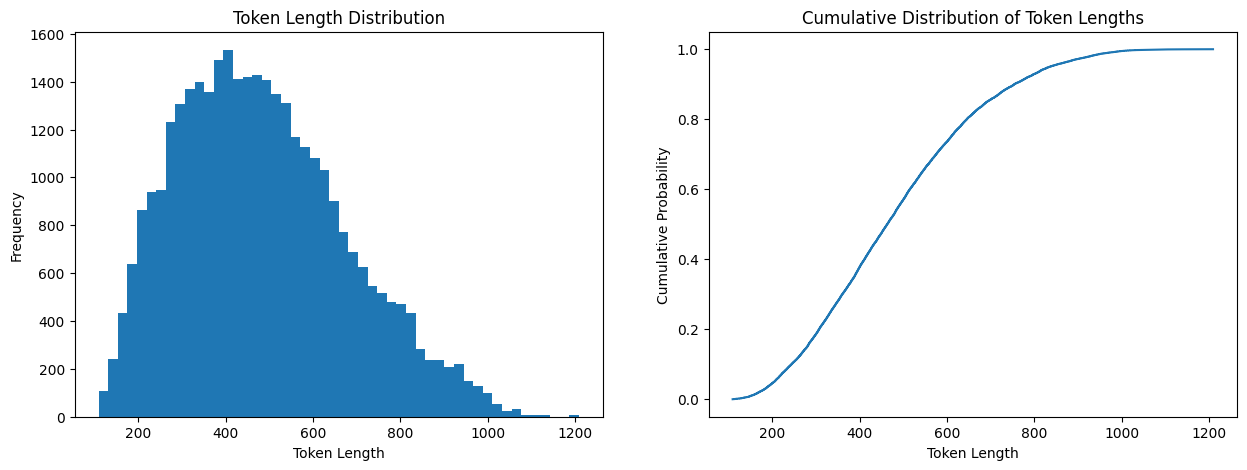

최대 길이: 1209
95퍼센트의 길이: 835.00
평균 길이: 482.84
중앙값 길이: 463.00
표준편차: 192.78



In [16]:
import matplotlib.pyplot as plt
import numpy as np

lengths = []
for example in dataset['train']:
    tokens = tokenizer(example['question'], example['context'], truncation=False)
    lengths.append(len(tokens['input_ids']))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(lengths, bins=50)
plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')

def cdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y

x, y = cdf(lengths)
plt.subplot(1, 2, 2)
plt.plot(x, y)
plt.title('Cumulative Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Cumulative Probability')
plt.show()

print(f"최대 길이: {np.max(lengths)}")
print("95퍼센트의 길이: {:.2f}".format(np.percentile(lengths, 95)))
print("평균 길이: {:.2f}".format(np.mean(lengths)))
print("중앙값 길이: {:.2f}".format(np.median(lengths)))
print("표준편차: {:.2f}\n".format(np.std(lengths)))

### 2) Start Point, End Point of Answers

In [ ]:
max_length = 1250

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
def preprocess_function(examples):
    question, context, answer = examples["question"], examples["context"], examples["answer"]
    def preprocess_text(text):
        text = text.replace('\n', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    question = preprocess_text(question)
    context = preprocess_text(context)
    answer = preprocess_text(answer)
    
    inputs = tokenizer(
        question,
        context,
        return_offsets_mapping=True,
        max_length=max_length, 
        truncation=True, 
        padding="max_length",
    )

    print(tokenizer.decode(inputs["input_ids"]))
    start_char = context.find(answer)
    end_char = start_char + len(answer)

    # offset_mapping: [(token1 start, token1 end), (token2 ~, ), ...]
    offset= inputs.pop("offset_mapping")
    
    # sequence_ids: (token=None, question=0, context=1)
    sequence_ids = inputs.sequence_ids(0)

    # 컨텍스트의 시작 및 마지막을 찾는다.
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # 만일 정답이 컨텍스트에 완전히 포함되지 않는다면, 레이블은 (0, 0)임
    if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
        start_position = 0
        end_position = 0
    else:
        # 그렇지 않으면 정답의 시작 및 마지막 인덱스
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_position = idx - 1

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_position = idx + 1

    inputs["start_positions"] = start_position
    inputs["end_positions"] = end_position
    return inputs

# 데이터 프레임을 전처리합니다
train_dataset = dataset["train"].map(preprocess_function)
train_dataset = train_dataset.remove_columns(['id', 'context', 'question', 'answer'])

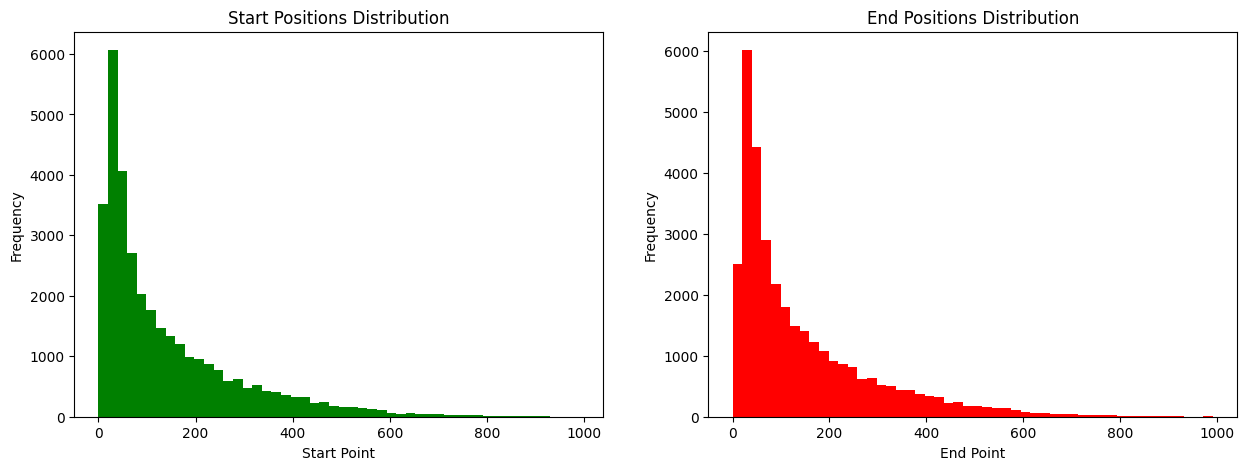

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(train_dataset['start_positions'], bins=50, color="green")
plt.title('Start Positions Distribution')
plt.xlabel('Start Point')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(train_dataset['end_positions'], bins=50, color="red")
plt.title('End Positions Distribution')
plt.xlabel('End Point')
plt.ylabel('Frequency')
plt.show()